### Import the libraries you need.
Other internal functions(nilean, keras, etc..) dosen't need to be imported.
Because mb-mvpa is wrapping.

In [1]:
from mbmvpa.preprocessing.bids import bids_preprocess
from mbmvpa.preprocessing.events import events_preprocess
from mbmvpa.data.loader import prepare_dataset
from mbmvpa.utils.example_utils import load_example_data

In [2]:
root = load_example_data('piva')

data load success! (piva)


### Preprocessing bids data including fMRI images

In [3]:
X, voxel_mask, layout = bids_preprocess(root=root, smoothing_fwhm=None, zoom=(2, 2, 2), ncore=2, nthread=2)

image preprocessing - fMRI data..                 :  67%|██████▋   | 4/6 [00:02<00:02,  1.31s/it]/home/mybirth0407/anaconda3/envs/mvpa/lib/python3.7/site-packages/scipy/ndimage/interpolation.py:478: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "
/home/mybirth0407/anaconda3/envs/mvpa/lib/python3.7/site-packages/scipy/ndimage/interpolation.py:478: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "
bids preprocessing done!                          :  83%|████████▎ | 5/6 [01:28<00:13, 13.74s/it]INFO:root:time elapsed: 1.47 minutes
INFO:root:masking data shape: (46, 55, 46)
bids preprocessing done!                          : 100%|██████████| 6/6 [01:28<00:00, 14.73s/it]


In [4]:
#todo: maskdata visualization

### Preprocessing event data

In [5]:
def example_piva_adjust_columns(row):
    ## rename data in a row to the name which can match hbayesdm.dd_hyperbolic requirements ##
    if row["delay_left"] >= row["delay_right"]:
        row["delay_later"] = row["delay_left"]
        row["delay_sooner"] = row["delay_right"]
        row["amount_later"] = row["money_left"]
        row["amount_sooner"] = row["money_right"]
        row["choice"] = 1 if row["choice"] == 1 else 0
    else:
        row["delay_later"] = row["delay_right"]
        row["delay_sooner"] = row["delay_left"]
        row["amount_later"] = row["money_right"]
        row["amount_sooner"] = row["money_left"]
        row["choice"] = 1 if row["choice"] == 2 else 0
    return row

In [6]:
def example_piva_condition(row):
    # in the paper, the condition for trial varies in a single run,
    # agent == 0 for making a choice for him or herself
    # agent == 1 for making a choice for other
    # to consider only non-social choice behavior, select only the cases with agent == 0
    return row["agent"] == 0

In [7]:
def example_piva_modulation(row, param_dict):
    # calculate subjective utility for choosing later option over sooner option
    # hyperbolic discount function is adopted
    ev_later = row["amount_later"] / (1 + param_dict["k"] * row["delay_later"])
    ev_sooner  = row["amount_sooner"] / (1 + param_dict["k"] * row["delay_sooner"])
    modulation = ev_later - ev_sooner
    row["modulation"] = modulation
    return row

In [8]:
dm_model, df_events, signals, time_masks, _ = \
    events_preprocess(layout=layout,
                      preprocess=example_piva_adjust_columns,
                      condition=example_piva_condition,
                      modulation=example_piva_modulation,
                      dm_model="dd_hyperbolic")

hbayesdm doing (model: dd_hyperbolic)..                      :  50%|█████     | 3/6 [00:01<00:02,  1.32it/s]INFO:numexpr.utils:Note: detected 88 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 88 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Using cached StanModel: cached-dd_hyperbolic-pystan_2.19.1.1.pkl

Model  = dd_hyperbolic
Data   = <pandas.DataFrame object>

Details:
 # of chains                    = 4
 # of cores used                = 1
 # of MCMC samples (per chain)  = 4000
 # of burn-in samples           = 1000
 # of subjects                  = 2
 # of (max) trials per subject  = 60

Using cached StanModel: cached-dd_hyperbolic-pystan_2.19.1.1.pkl


calculating modulation..                          :  67%|██████▋   | 4/6 [00:30<00:09,  4.86s/it]           

Index(['onset', 'duration', 'choice', 'agent', 'moneyleft', 'delayleft',
       'moneyright', 'delayright', 'subjid', 'run', 'session', 'delaylater',
       'delaysooner', 'amountlater', 'amountsooner'],
      dtype='object')
['onset', 'duration', 'choice', 'agent', 'money_left', 'delay_left', 'money_right', 'delay_right', 'subjID', 'run', 'session', 'delay_later', 'delay_sooner', 'amount_later', 'amount_sooner']
************************************
**** Model fitting is complete! ****
************************************
   subjID         k      beta
0       1  0.008680  0.712656
1       2  0.233402  0.426442


events preproecssing done! 0.51 minutes                                     : 100%|██████████| 6/6 [00:30<00:00,  5.13s/it]


### Load data and shape check

In [9]:
X, y, voxel_mask = prepare_dataset(root=layout.derivatives["fMRIPrep"].root)

In [10]:
X.shape, y.shape

((844, 1977), (844,))

### Fitting MVPA models & Results

In [11]:
from mbmvpa.utils.coef2map import get_map
import time

In [12]:
from mbmvpa.models.regressor import mlp_regression

s = time.time()
coefs = mlp_regression(X, y,
                       layout,
                       layer_dims=[1024, 1024],
                       N=30,
                       verbose=1)
task_name = "piva2019_mlp"
result = get_map(coefs, voxel_mask, task_name=task_name, map_type='z', save=True, save_path='./results', sigma=1)
e = time.time()
print(f"elapsed time: {(e-s) / 60:.2f} minutes")

INFO:root:start running
INFO:root:[1/30] - val_loss: 0.4696
INFO:root:[2/30] - val_loss: 0.4092
INFO:root:[3/30] - val_loss: 0.3787
INFO:root:[4/30] - val_loss: 0.4424
INFO:root:[5/30] - val_loss: 0.4089
INFO:root:[6/30] - val_loss: 0.4587
INFO:root:[7/30] - val_loss: 0.3838
INFO:root:[8/30] - val_loss: 0.4328
INFO:root:[9/30] - val_loss: 0.4033
INFO:root:[10/30] - val_loss: 0.4149
INFO:root:[11/30] - val_loss: 0.4377
INFO:root:[12/30] - val_loss: 0.4412
INFO:root:[13/30] - val_loss: 0.4282
INFO:root:[14/30] - val_loss: 0.4722
INFO:root:[15/30] - val_loss: 0.4357
INFO:root:[16/30] - val_loss: 0.3987
INFO:root:[17/30] - val_loss: 0.4239
INFO:root:[18/30] - val_loss: 0.4095
INFO:root:[19/30] - val_loss: 0.3783
INFO:root:[20/30] - val_loss: 0.3938
INFO:root:[21/30] - val_loss: 0.4404
INFO:root:[22/30] - val_loss: 0.4319
INFO:root:[23/30] - val_loss: 0.4618
INFO:root:[24/30] - val_loss: 0.3948
INFO:root:[25/30] - val_loss: 0.4088
INFO:root:[26/30] - val_loss: 0.4132
INFO:root:[27/30] - val

elapsed time: 5.18 minutes


INFO:root:start running
INFO:root:[1/1] - lambda_best: 1.000/ mse: 0.1508


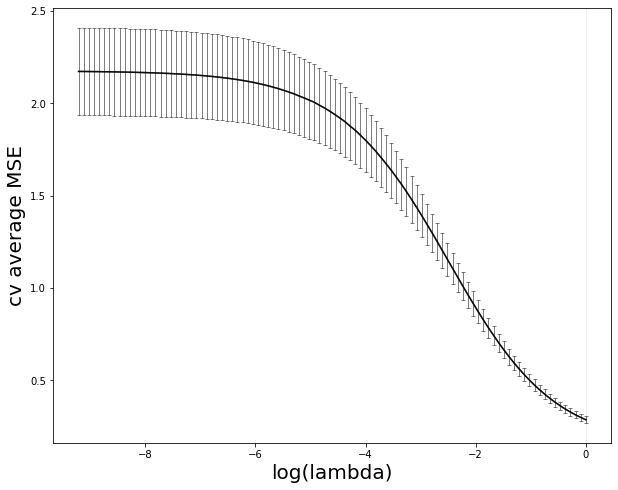

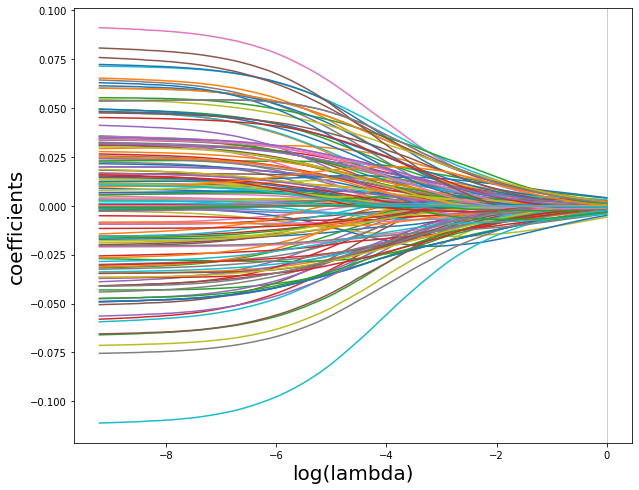

elapsed time: 0.08 minutes


In [13]:
from mbmvpa.models.regressor import elasticnet

s = time.time()
coefs = elasticnet(X, y,
                   layout,
                   alpha=0.005,
                   n_jobs=16,
                   verbose=1,
                   max_lambda=1,
                   n_samples=5000)
task_name = f"piva2019_elasticnet"
result = get_map(coefs, voxel_mask, task_name=task_name, map_type='z', save=True, save_path='./results', sigma=1)
e = time.time()
print(f"elapsed time: {(e-s) / 60:.2f} minutes")